# Renewable Power and Storage

This notebook looks at data for the variable renewable power generators and storage units in the PyPSA-GB dataset. For historical years, 2010-2020, data on operational solar photovoltaics (PV), onshore wind, and offshore wind sites is sourced from the Renewable Energy Planning Database (REPD) https://www.gov.uk/government/publications/renewable-energy-planning-database-monthly-extract. Geocoordinates, technology type, and installed capacity are extracted and used for PyPSA generator components, as well as to generate power timeseries using Atlite.

For modelling future energy scenarios, the FES2021 and FES2022 workbooks can be used to extract projected capacities. The spatial distribution of PV and onshore wind from 2020 is used as a baseline for future years and is scaled up based on projected capacities. For offshore wind in the near future (to 2030), the pipeline (from the REPD) and Sectoral Marine Plan (planning sites around Scotland) are used to update the spatial distribution from 2020 as it is anticipated that there will be a large expansion of offshore wind in the next 10 years which will significantly impact the current spatial distribution. From 2030 to 2050 it is assumed that the spatial distribution of offshore wind, along with PV and onshore wind, will be static.

The only historical storage units for 2010-2020 included are large-scale pumped hydro stations. The future storage technologies represented are pumped hydro, batteries, liquid air storage and compressed air storage. The energy capacities and nominal power for the years 2021-2050 are extracted from the FES2021 or FES2022 workbook, and can be obtained for the four different scenarios. Storage technical parameters are sourced from https://www.sciencedirect.com/book/9780444626165/electrochemical-energy-storage-for-renewable-sources-and-grid-balancing.

## Mapping historical renewable power sites

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import mapping
import renewables
import generators
import snapshots

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature
from statistics import mean
import imageio

In [3]:
# tech = 'Advanced Conversion Technology'
# tech = 'Anaerobic Digestion'
# tech = 'Biomass (co-firing)'
# tech = 'Biomass (dedicated)'
# tech = 'EfW Incineration'
# tech = 'Fuel Cell (Hydrogen)'
# tech = 'Hot Dry Rocks (HDR)'
# tech = 'Landfill Gas'
# tech = 'Large Hydro'
# tech = 'Pumped Storage Hydroelectricity'
# tech = 'Sewage Sludge Digestion'
# tech = 'Shoreline Wave'
# tech = 'Small Hydro'
tech = 'Solar Photovoltaics'
# tech = 'Tidal Barrage and Tidal Stream'
# tech = 'Wind Offshore'
# tech = 'Wind Onshore'
# tech = 'Biomass (co-firing)'

In [4]:
color = 'deepskyblue'
marker_scaler = 2.
year = 2020

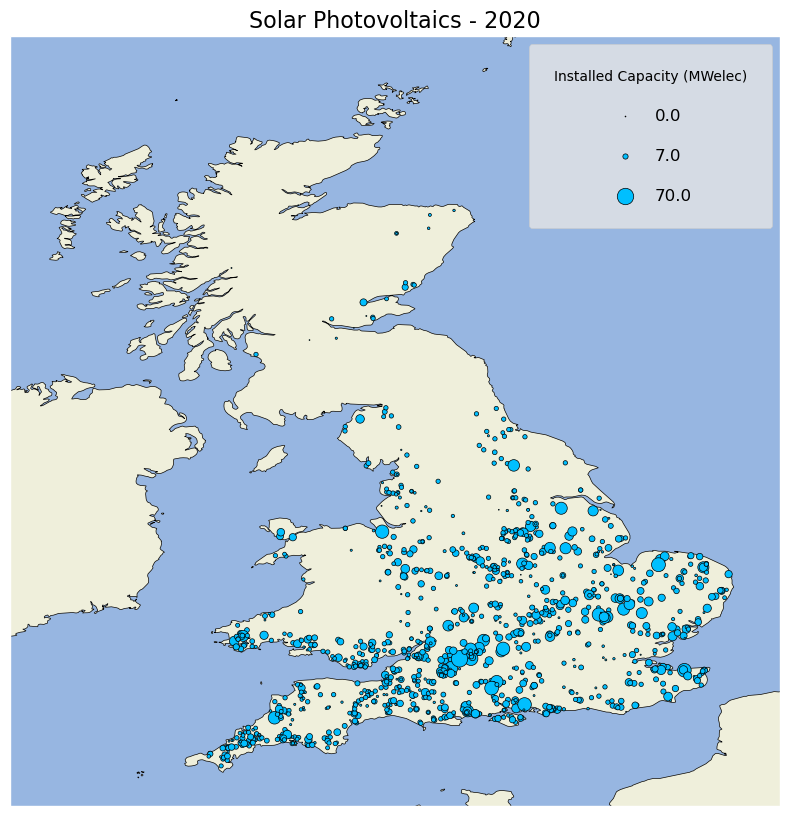

In [5]:
df = renewables.REPD_date_corrected(year)
df_res = df.loc[df['Technology Type'] == tech].reset_index(drop=True)

lon = df_res['lon'].values
lat = df_res['lat'].values

sizes = df_res['Installed Capacity (MWelec)'].values

plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

extent = [-8.09782, 2.40511, 60, 49.5]
ax.set_extent(extent)
# ax.stock_img()
# ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.scatter(lon, lat, s=sizes * marker_scaler, c=color, edgecolors='black')
ax.set_title(tech + ' - ' + str(year), fontsize=16)
l1 = ax.scatter([], [], s=min(sizes) * marker_scaler, edgecolors='black', color=color)
l2 = ax.scatter([], [], s=mean(sizes) * marker_scaler, edgecolors='black', color=color)
l3 = ax.scatter([], [], s=max(sizes) * marker_scaler, edgecolors='black', color=color)

label1 = round(min(sizes), 0)
label2 = round(mean(sizes), 0)
label3 = round(max(sizes), 0)
labels = [label1, label2, label3]
ax.legend([l1, l2, l3], labels, frameon=True, fontsize=12,
          loc=1, borderpad=1.5, labelspacing=1.5,
          title='Installed Capacity (MWelec)', scatterpoints=1)
# plt.savefig('../data/FES2021/' + str(year) + '_' + tech + '.png')
plt.show()

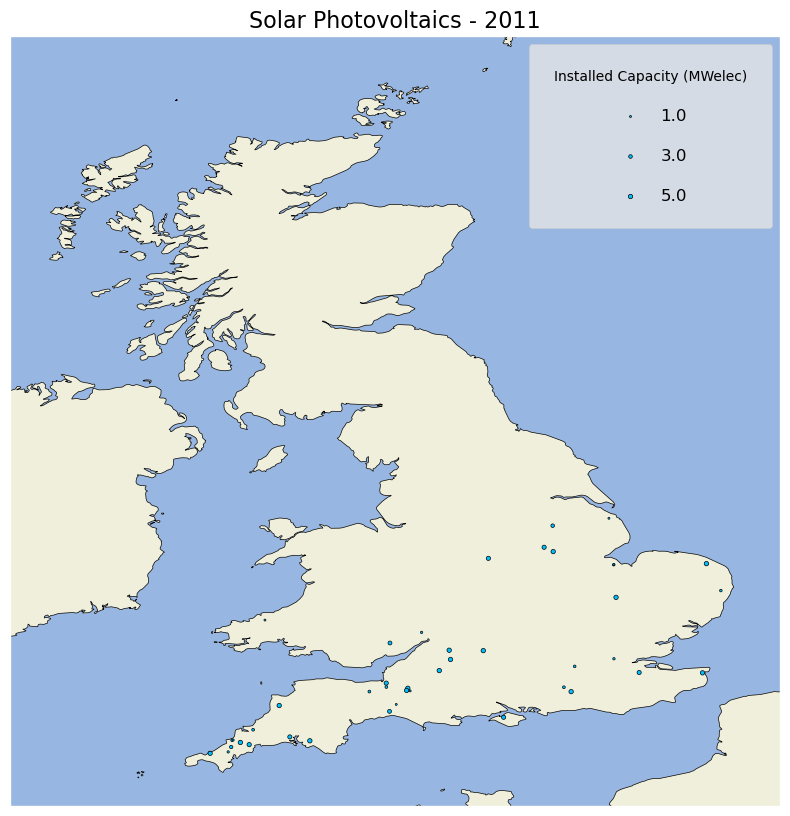

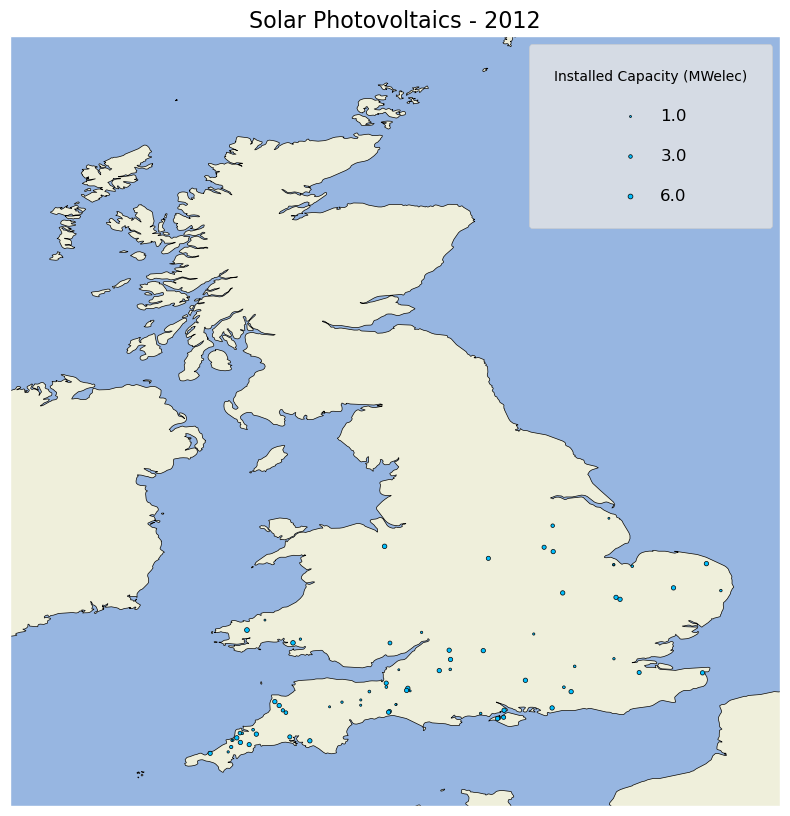

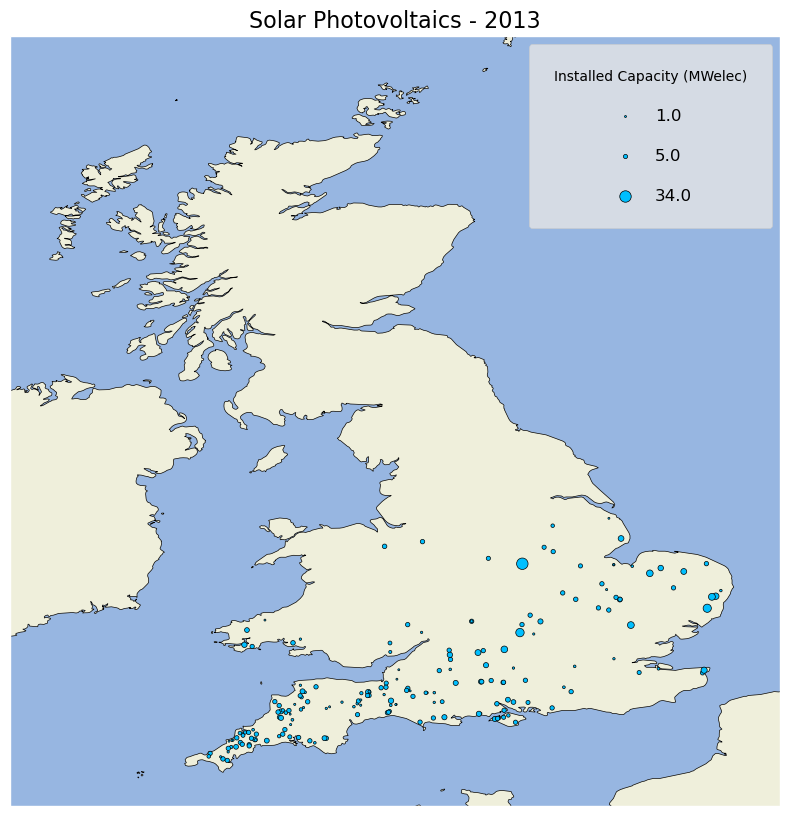

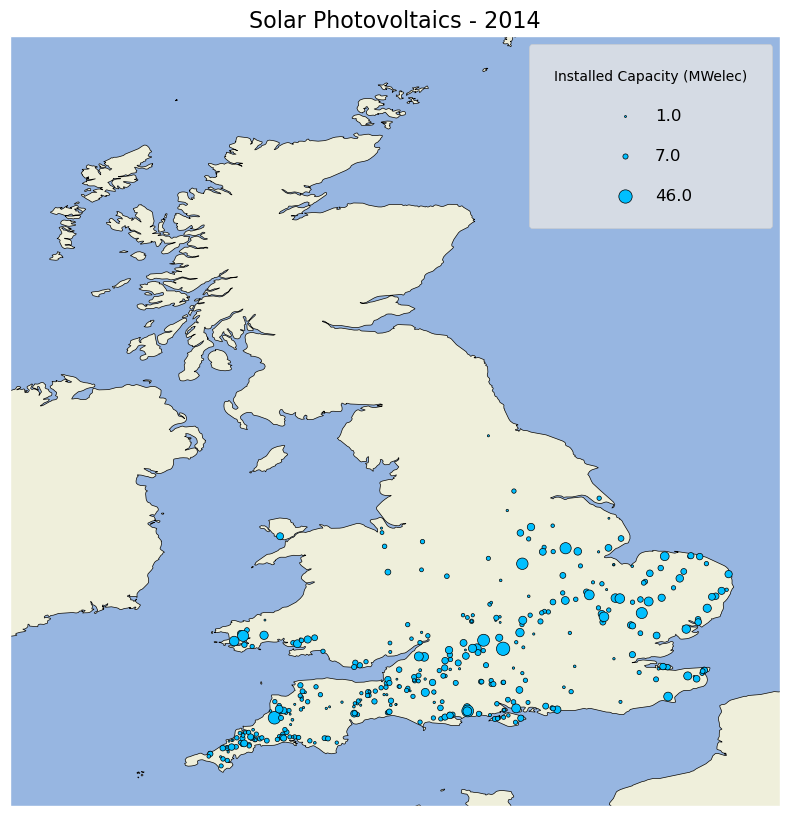

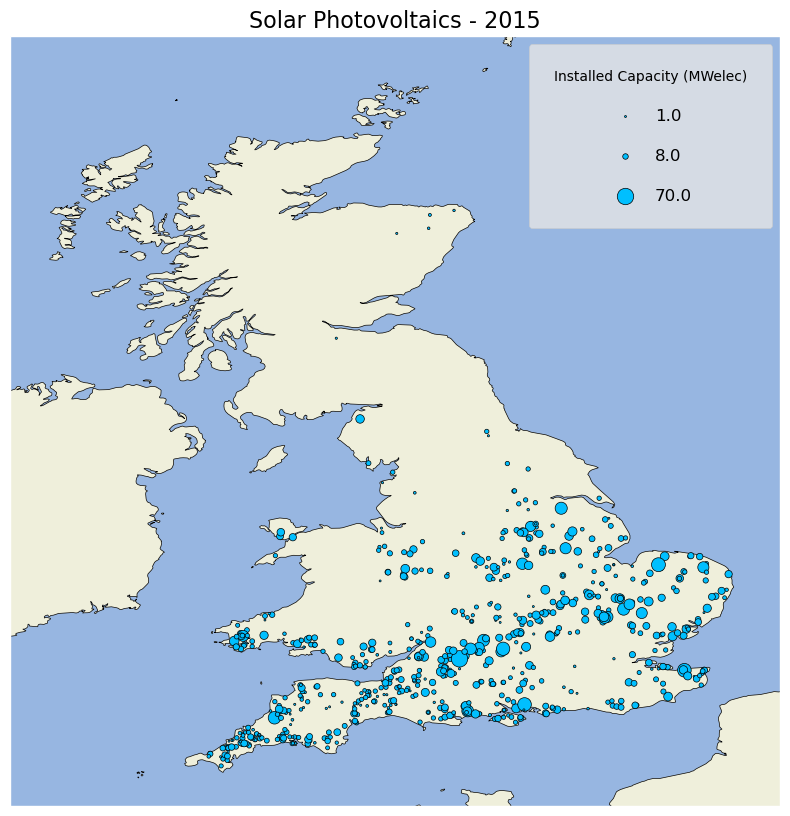

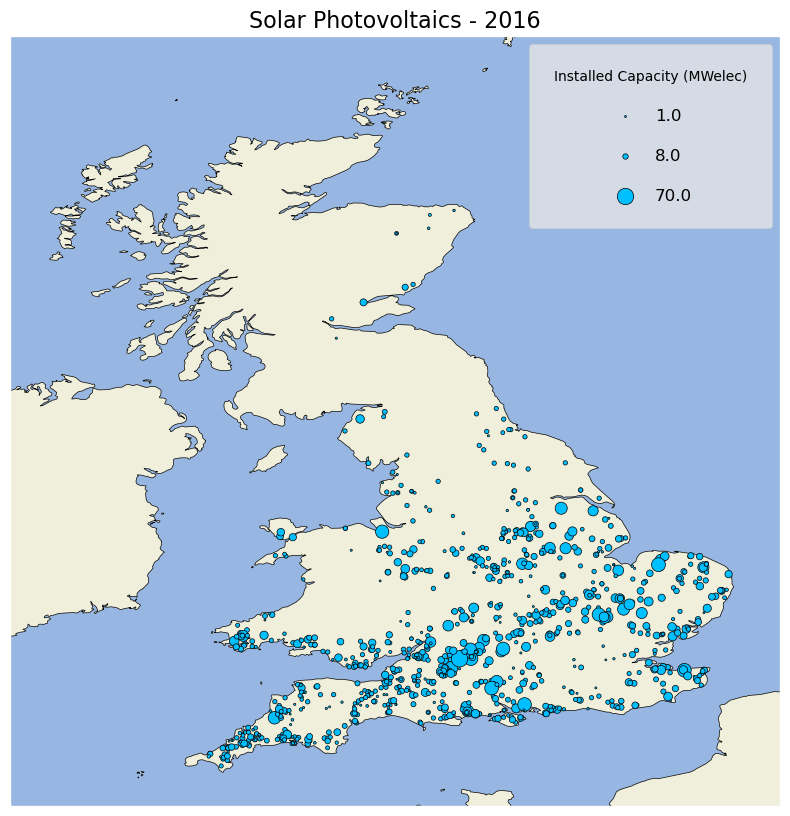

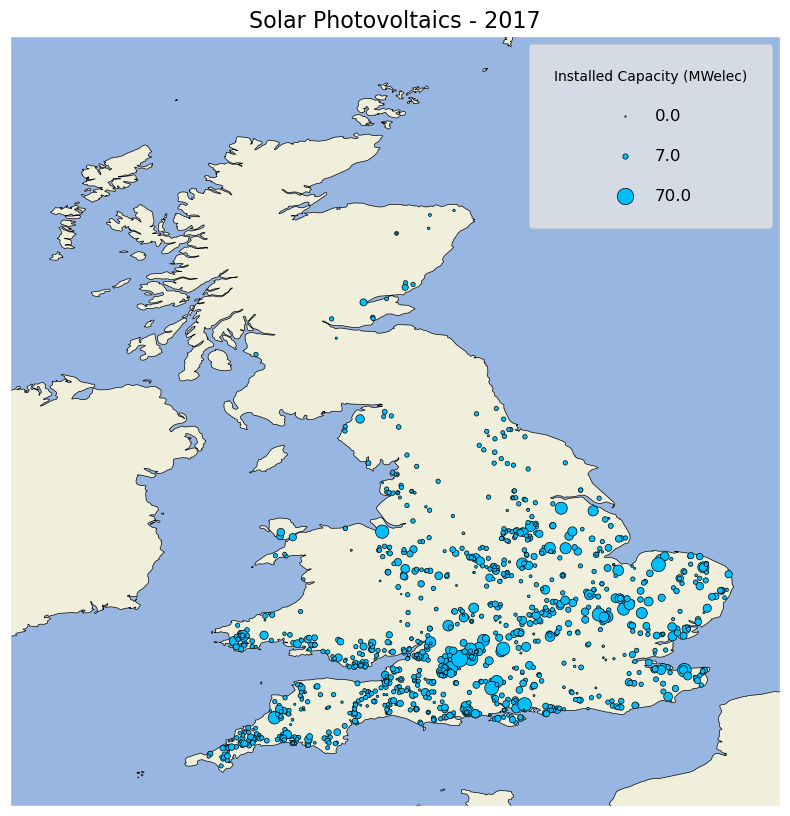

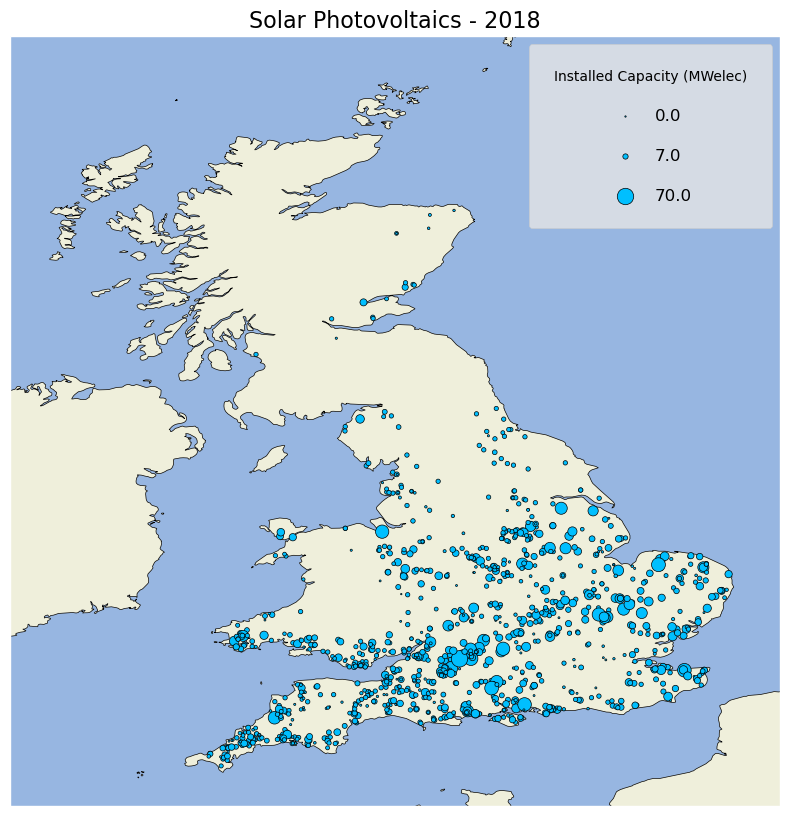

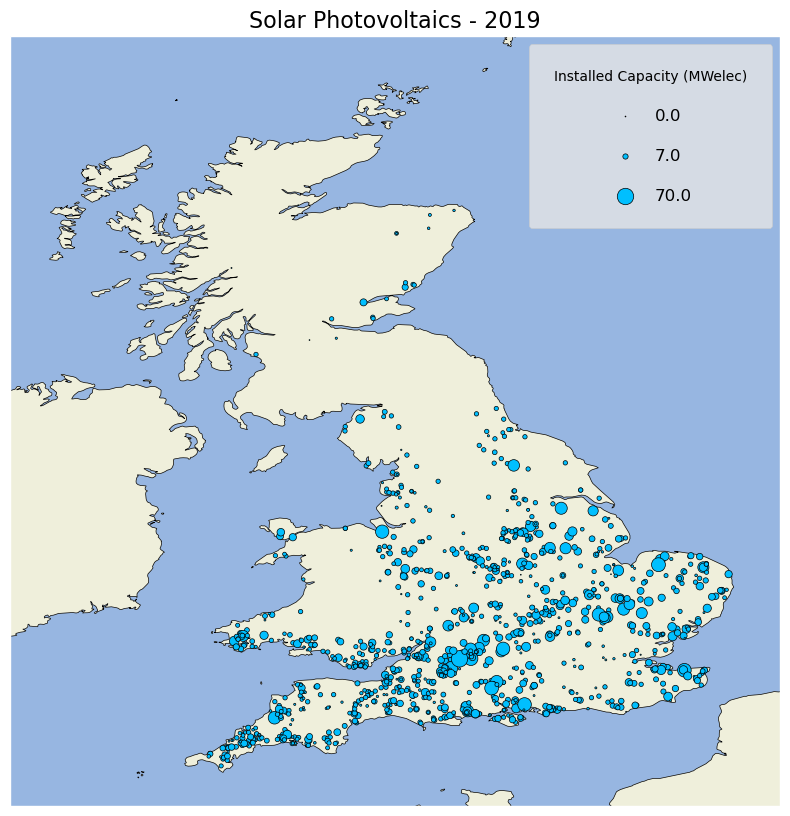

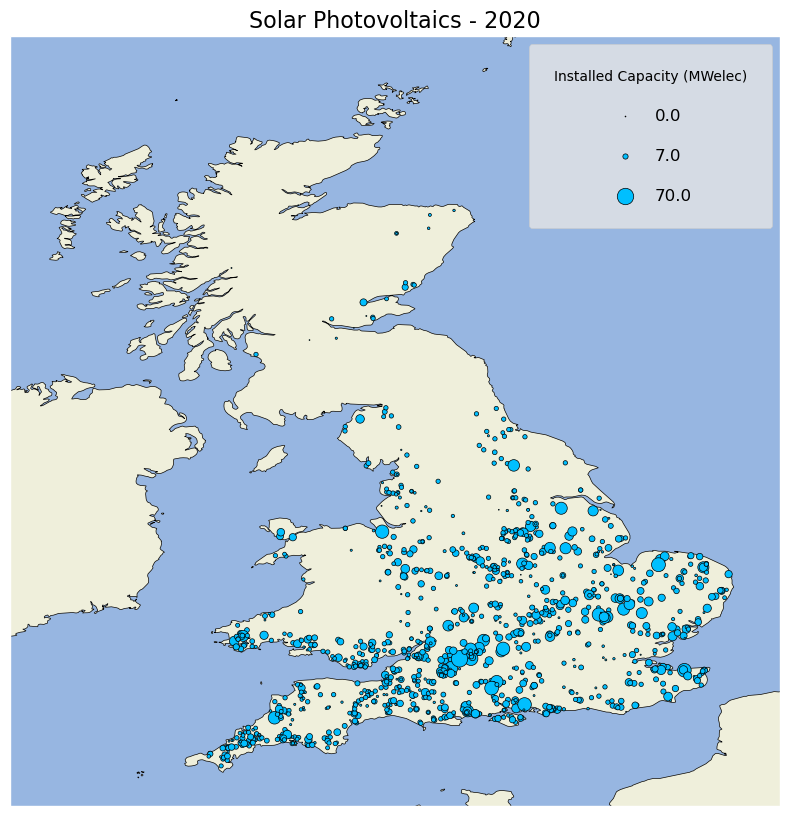

In [6]:
# do for all years
for y in range(2011, 2020 + 1):
    mapping.generator_map_plotter(tech, color, marker_scaler, y)

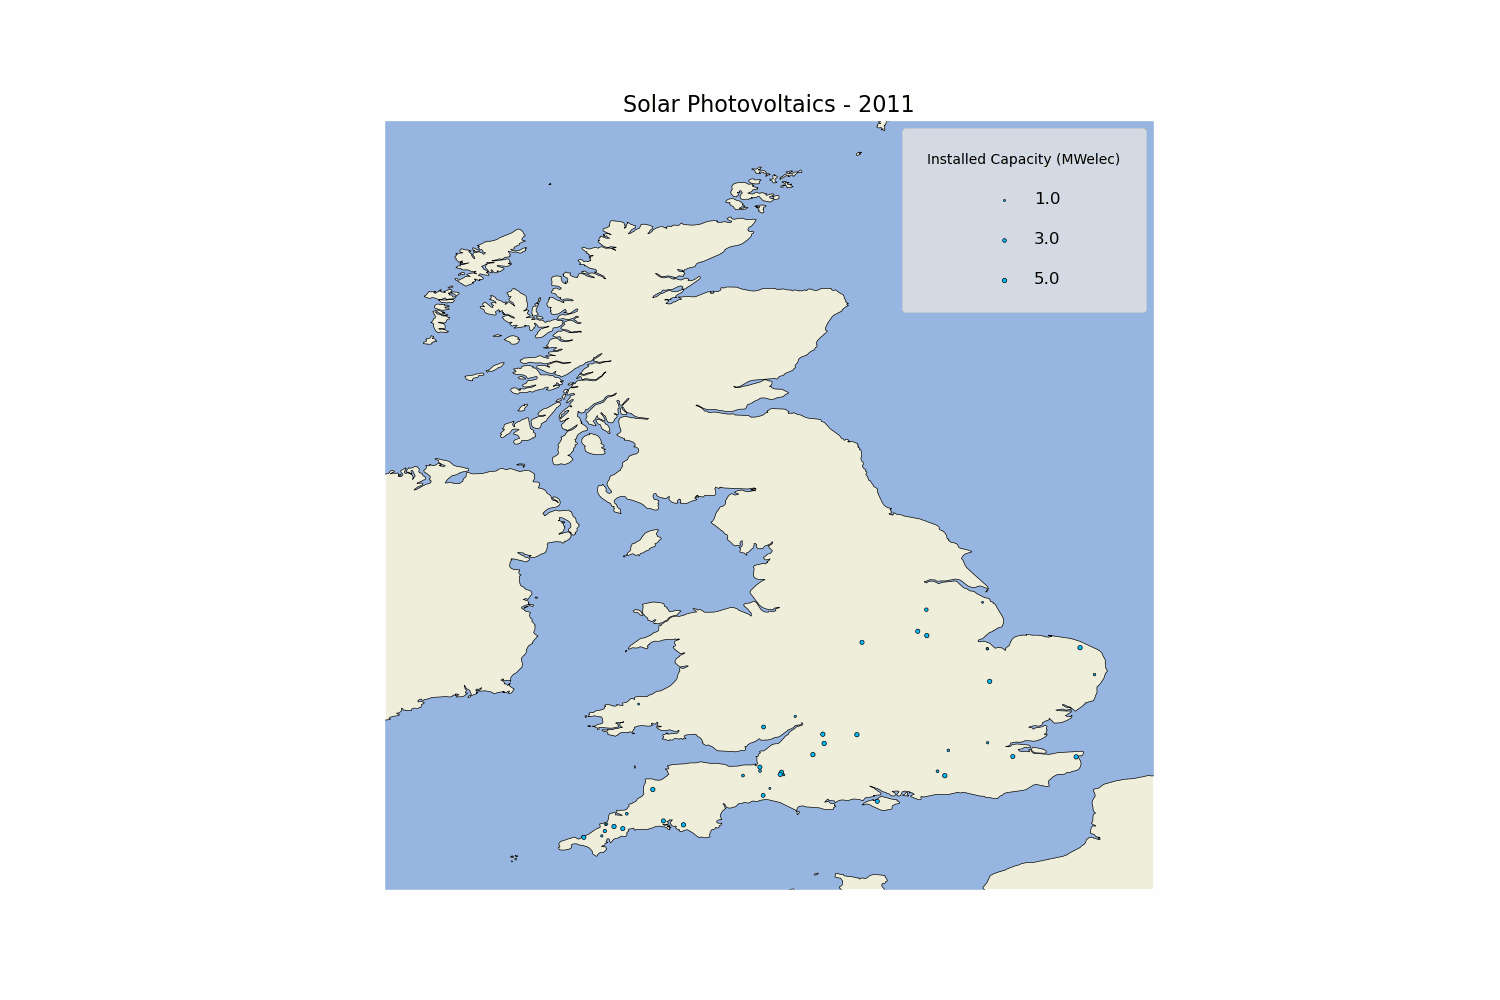

In [7]:
mapping.gif_maker(tech)

file = '../data/renewables/' + tech + '.gif'
from IPython.display import Image
Image(filename=file)

## Historical renewable correction factors

Historical annual power output from different renewable power generators is reported by BEIS and this is compared to the power output calculated using Atlite.

In [8]:
df = renewables.RES_correction_factors()
df

2010      2011      2012      2013      2014      2015  \
Wind_Offshore  0.733633  0.775553  0.836134  0.742069  0.782873  0.770685   
Wind_Onshore   1.029483  0.976941  1.029872  0.938289  0.941133  0.936483   
PV                  NaN  4.831223  6.487221  2.799122  1.964904  1.527666   

                   2016      2017      2018      2019      2020  
Wind_Offshore  0.732413  0.792680  0.820076  0.871102  0.878444  
Wind_Onshore   0.926565  0.956799  0.941639  0.969856  0.908810  
PV             1.407315  1.438742  1.461258  1.437970  1.461977

Both wind onshore and offshore power production are overestimated, and this is likely due to a combination of limitations with use of reanalysis datasets, neglecting of wake effects, and maintenance/down town. However, there is an underestimation of PV power production and this is because <150kW installations are not included in the REPD, which means that domestic scale systems are not included. By presuming the spatial distribution of <150kW systems is the same as >150kW systems we can scale the power capacities of the PV generators to match historical data.

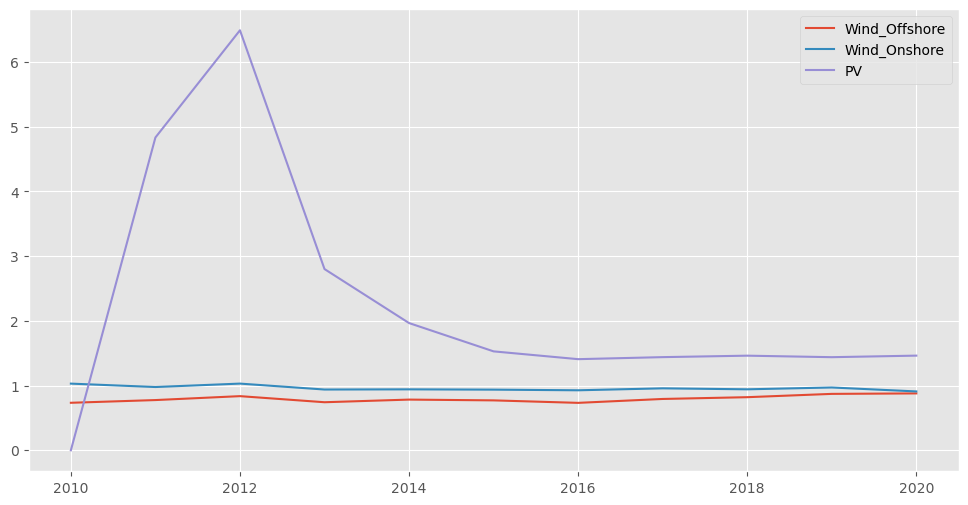

In [9]:
df.loc['PV', 2010] = 0
plt.figure(figsize=(12, 6))
plt.plot(df.loc['Wind_Offshore'])
plt.plot(df.loc['Wind_Onshore'])
plt.plot(df.loc['PV'])
plt.legend(df.index)

## Closer look at renewable power generation timeseries

Choose a year to analyse, and if future year then choose a baseline year in the following cell.

In [10]:
year = 2050

In [11]:
start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:30:00'

# time step as fraction of hour
time_step = 0.5
freq = snapshots.write_snapshots(start, end, time_step)

# write generators contains the applying correction factors function
generators.write_generators(time_step, year)

if year > 2020:
    # if future choose a baseline year
    year_baseline = 2019
    scenario = 'Leading The Way'
    generators.future_p_nom(year, time_step, scenario, FES=2022)
    generators.write_generators_p_max_pu(start, end, freq, year, 2022, year_baseline=year_baseline, scenario=scenario)
    generators.unmet_load()

elif year <= 2020:
    generators.write_generators_p_max_pu(start, end, freq, year, 2022)

df_RES = pd.read_csv('LOPF_data/generators-p_max_pu.csv', index_col=0)
df_RES

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\generators.py:795: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df.index = pd.to_datetime(df.index, infer_datetime_format=True)
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_point = {'lon': df['x'][i], 'lat': df['y'][i]}
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB v0.0.1\PyPSA-GB\distance_calculator.py:32: FutureWarning: Series.__getitem__ treating keys as positions is

Hywind Scotland Pilot Park (Hywind 2) Demonstrator  \
name                                                                      
2050-01-01 00:00:00                                           1.000000    
2050-01-01 00:30:00                                           1.000000    
2050-01-01 01:00:00                                           1.000000    
2050-01-01 01:30:00                                           1.000000    
2050-01-01 02:00:00                                           1.000000    
...                                                                ...    
2050-12-31 21:30:00                                           0.959733    
2050-12-31 22:00:00                                           0.966778    
2050-12-31 22:30:00                                           0.962127    
2050-12-31 23:00:00                                           0.945779    
2050-12-31 23:30:00                                           0.945779    

                     Beatrice Demonstrator  Burbo Bank  \
name                                                     
2050-01-01 00:00:00               1.000000    0.998449   
2050-01-01 00:30:00               1.000000    0.998630   
2050-01-01 01:00:00               1.000000    0.998549   
2050-01-01 01:30:00               1.000000    0.998207   
2050-01-01 02:00:00               1.000000    0.997720   
...                                    ...         ...   
2050-12-31 21:30:00               0.286398    0.224614   
2050-12-31 22:00:00               0.272982    0.182529   
2050-12-31 22:30:00               0.289324    0.183538   
2050-12-31 23:00:00               0.335424    0.227640   
2050-12-31 23:30:00               0.335424    0.227640   

                     Gunfleet Sands - (Demo) Extension  Gunfleet Sands II  \
name                                                                        
2050-01-01 00:00:00                           0.355643           0.450097   
2050-01-01 00:30:00                           0.356263           0.449326   
2050-01-01 01:00:00                           0.363484           0.457552   
2050-01-01 01:30:00                           0.377306           0.474776   
2050-01-01 02:00:00                           0.404703           0.510393   
...                                                ...                ...   
2050-12-31 21:30:00                           0.522030           0.647349   
2050-12-31 22:00:00                           0.436542           0.551402   
2050-12-31 22:30:00                           0.407859           0.519177   
2050-12-31 23:00:00                           0.435981           0.550676   
2050-12-31 23:30:00                           0.435981           0.550676   

                     Gunfleet Sands Offshore Wind Scheme  Inner Dowsing  \
name                                                                      
2050-01-01 00:00:00                             0.450097       0.993255   
2050-01-01 00:30:00                             0.449326       0.994529   
2050-01-01 01:00:00                             0.457552       0.995643   
2050-01-01 01:30:00                             0.474776       0.996597   
2050-01-01 02:00:00                             0.510393       0.997287   
...                                                  ...            ...   
2050-12-31 21:30:00                             0.647349       0.315004   
2050-12-31 22:00:00                             0.551402       0.285380   
2050-12-31 22:30:00                             0.519177       0.290130   
2050-12-31 23:00:00                             0.550676       0.329255   
2050-12-31 23:30:00                             0.550676       0.329255   

                     Kentish Flats      Lynn  North Hoyle  ...  \
name                                                       ...   
2050-01-01 00:00:00       0.331019  0.993255     0.998194  ...   
2050-01-01 00:30:00       0.323019  0.994529     0.998592  ...   
2050-01-01 01:00:00       0.323650  0.995643    

Pick one renewable generator to plot the timeseries of.

In [12]:
df_RES.columns.values.tolist()

['Hywind Scotland Pilot Park (Hywind 2) Demonstrator',
 'Beatrice Demonstrator',
 'Burbo Bank',
 'Gunfleet Sands - (Demo) Extension',
 'Gunfleet Sands II',
 'Gunfleet Sands Offshore Wind Scheme',
 'Inner Dowsing',
 'Kentish Flats',
 'Lynn',
 'North Hoyle',
 'Rhyl Flats',
 'Robin Rigg East',
 'Robin Rigg West',
 'Scroby Sands',
 'Thanet',
 'Walney 1',
 'Kentish Flats 2',
 'European Offshore Wind Deployment Centre (EOWDC) (Aberdeen Bay - Demonstration site)',
 'Walney 2',
 'Ormonde Offshore',
 'Greater Gabbard Wind Farm',
 'London Array Phase 1',
 'Sheringham Shoal',
 'Centrica (Lincs)',
 'Teeside Offshore Wind Farm',
 'Race Bank (Phase 1)',
 'West of Duddon Sands',
 'Rampion Offshore Wind Farm (Hastings Zone)',
 'Beatrice',
 'Blyth Offshore Wind Test Site',
 'East Anglia 1 (EA 1)',
 'Hornsea 1 - Heron & Njord',
 'Galloper Wind Farm',
 'Levenmouth demonstration turbine (Fife Energy Park)',
 'Walney 3',
 'Dudgeon East',
 'Burbo Bank Extension (Burbo Bank 2)',
 'Gwynt y Mor',
 'Humber Gate

In [13]:
whitelee = df_RES.loc[:, 'Whitelee']
whitelee = df_RES[['Whitelee']]
whitelee

Whitelee
name                         
2050-01-01 00:00:00  0.915911
2050-01-01 00:30:00  0.767069
2050-01-01 01:00:00  0.632692
2050-01-01 01:30:00  0.512778
2050-01-01 02:00:00  0.407853
...                       ...
2050-12-31 21:30:00  0.114266
2050-12-31 22:00:00  0.124903
2050-12-31 22:30:00  0.135496
2050-12-31 23:00:00  0.146044
2050-12-31 23:30:00  0.146044

[17520 rows x 1 columns]

Text(0, 0.5, 'Power normalised')

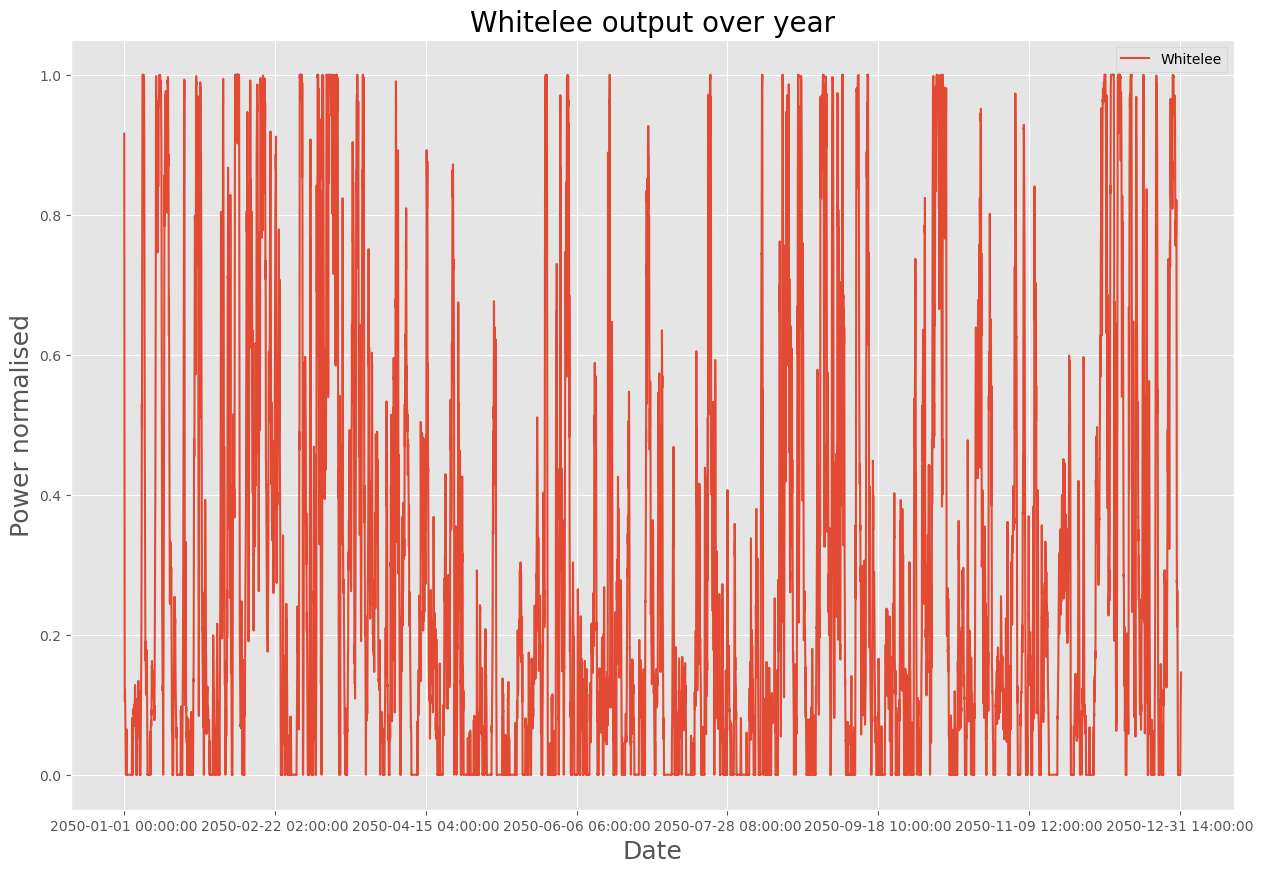

In [14]:
whitelee.plot(linestyle='-', figsize=(15,10))
plt.title('Whitelee output over year', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Power normalised', fontsize=18)

Text(0, 0.5, 'Power normalised')

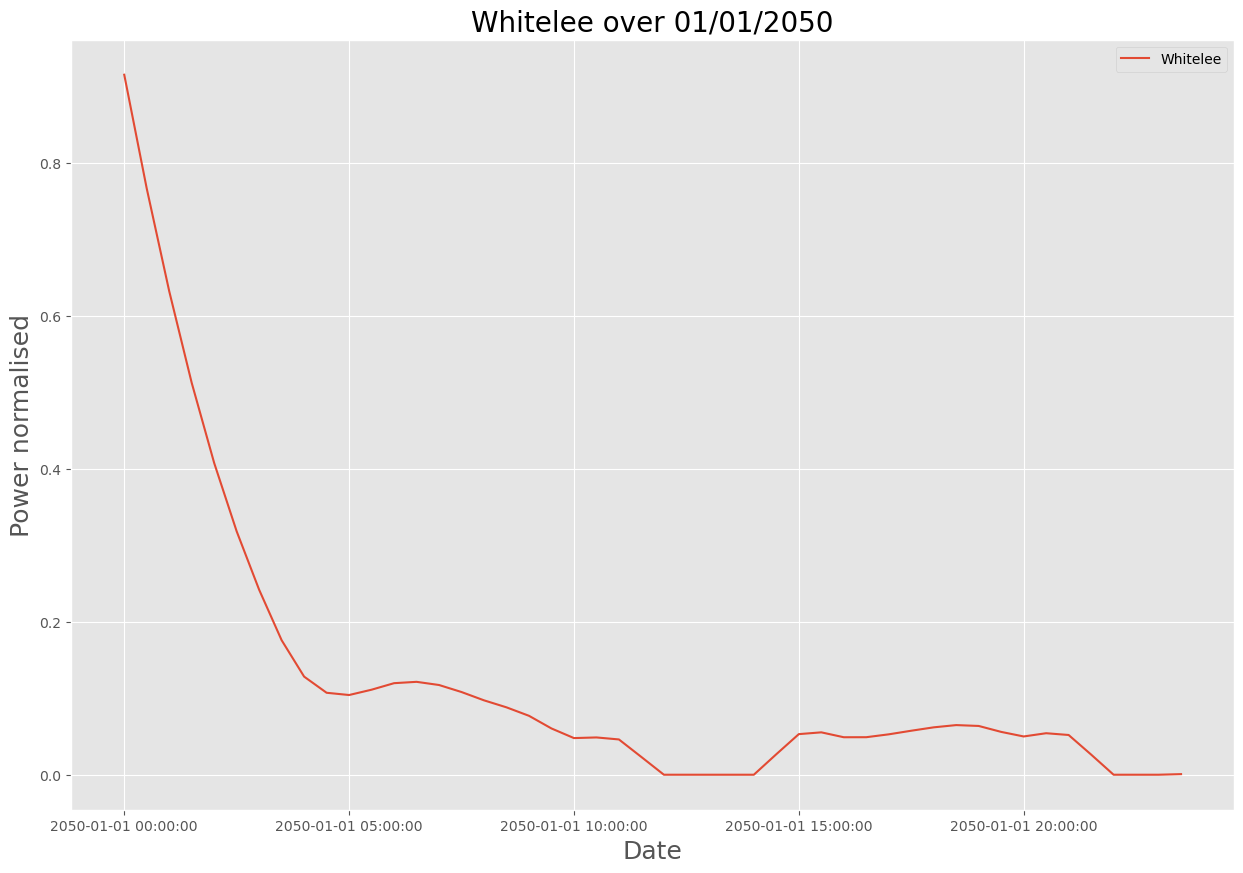

In [15]:
whitelee['2050-01-01 00:00:00': '2050-01-01 23:30:00'].plot(linestyle='-', figsize=(15,10))
plt.title('Whitelee over 01/01/' + str(year), fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Power normalised', fontsize=18)

C:\Users\alyden\AppData\Local\Temp\ipykernel_16456\3196715207.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s_index = pd.to_datetime(s, infer_datetime_format=True)


Text(0, 0.5, 'Supply [kWh]')

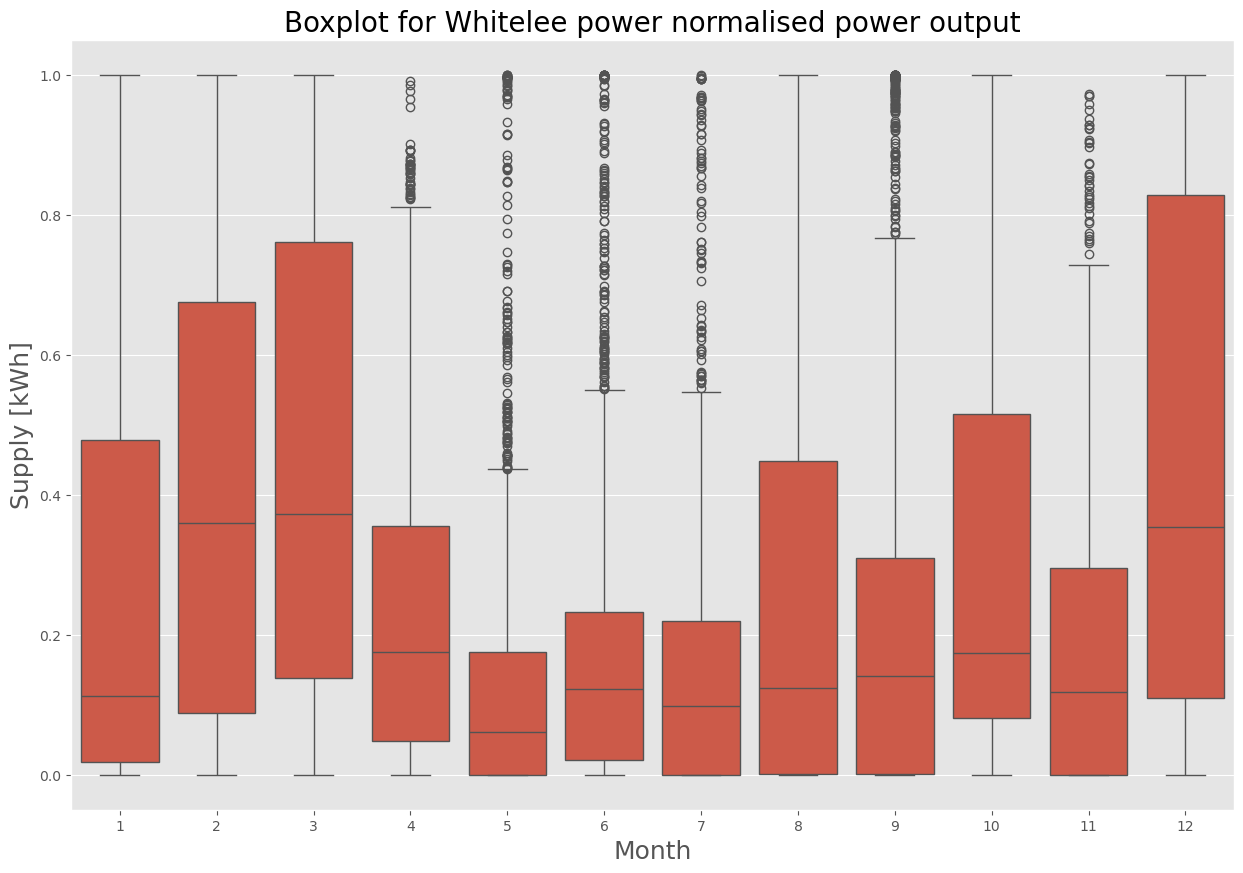

In [16]:
s = whitelee.index
s_index = pd.to_datetime(s, infer_datetime_format=True)
whitelee.index = s_index
whitelee.loc[:, 'Month'] = whitelee.index.month
# Box plots over whole dataset for month values
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.boxplot(data=whitelee, x='Month', y='Whitelee')
ax.set_title('Boxplot for Whitelee power normalised power output', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

## Historical storage units

In [17]:
import storage
year = 2015
storage.read_storage_data(year)

name  bus  p_nom                       carrier  marginal_cost  \
0    Dinorwig  bus   1728  Pumped Storage Hydroelectric              0   
1  Ffestiniog  bus    360  Pumped Storage Hydroelectric              0   
2    Cruachan  bus    440  Pumped Storage Hydroelectric              0   
3      Foyers  bus    300  Pumped Storage Hydroelectric              0   

   max_hours  efficiency_store  efficiency_dispatch         x          y  
0      5.266             0.865                0.865 -4.113899  53.118623  
1      3.889             0.850                0.850 -3.968897  52.980848  
2     16.136             0.865                0.865 -5.113430  56.411140  
3     21.000             0.865                0.865 -4.493816  57.254341

In [19]:
df_storage = storage.write_storage_units(year, scenario='Leading the Way', FES=2022)
storage_p_nom = df_storage.p_nom.groupby(df_storage.carrier).sum()
storage_p_nom

carrier
Pumped Storage Hydroelectric    2828
Name: p_nom, dtype: int64